In [1]:
import os
import glob
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from copy import deepcopy

from gensit.config import Config
from gensit.inputs import Inputs
from gensit.outputs import Outputs
from gensit.utils.misc_utils import *
from gensit.utils.math_utils import *
from gensit.utils.probability_utils import *
from gensit.contingency_table import instantiate_ct
from gensit.markov_basis import instantiate_markov_basis

In [2]:
%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

## Import samples

In [4]:
# Specify experiment id
experiment_id = "SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_13_33_24"
config_id = 'experiment_r_squared'
# 'experiment1_disjoint'
# 'experiment_r_squared'
# Specify experiment group id
dataset = 'DC'
#'DC'
#'cambridge_work_commuter_lsoas_to_msoas'
#'sioux_falls'
experiment_group_id = 'exp1/'
experiment_dir = f'../data/outputs/{dataset}/{experiment_group_id}/{experiment_id}/'
relative_experiment_dir = os.path.relpath(experiment_dir,os.getcwd())

In [5]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'INFO',
    file_level = 'EMPTY'
)

In [31]:
# Output processing settings
settings = {
    "logging_mode": "INFO",
    "coordinate_slice": [
        "da.loss_name == str(['dest_attraction_ts_likelihood_loss'])"
    ],
    #     "da.destination_attraction_ts == str('destination_attraction_demand_ts_sum_normalised.txt')",
    #     "da.cost_matrix == str('cost_matrix_large_diagonal_sum_normalised.txt')",
    #     "da.bmax == 10944.0"
        # "da.loss_name == str(['dest_attraction_ts_likelihood_loss'])",
        # "~da.title.isin([str('_unconstrained'), str('_total_constrained')])"
    # ],
    "metadata_keys":[],
    "burnin_thinning_trimming": [],
    # {'iter': {"burnin":10000, "thinning":90, "trimming":1000}}
    "n_workers": 1,
    "group_by":[],
    "filename_ending":"test",
    "sample":["intensity"],
    "force_reload":True
}

In [32]:
# Initialise outputs
current_sweep_outputs = Outputs(
    config = os.path.join(relative_experiment_dir,"config.json"),
    settings = settings,
    inputs = None,
    slice = True,
    level = 'INFO'
)
# Silence outputs
current_sweep_outputs.logger.setLevels(console_level='EMPTY')
# Load all data
current_sweep_outputs.load()

50:31.931 config INFO ----------------------------------------------------------------------------------
50:31.941 config INFO Parameter space size: 
 --- name (2)
 --- sigma: ['sigma', 'to_learn'] (3)
 --- loss_name: ['loss_name', 'loss_function', 'loss_kwargs'] (2)
50:31.950 config INFO Total = 12.
50:31.959 config INFO ----------------------------------------------------------------------------------
50:31.978 outputs INFO //////////////////////////////////////////////////////////////////////////////////
50:31.986 outputs INFO Slicing coordinates:
50:31.995 outputs INFO loss_name == str(['dest_attraction_ts_likelihood_loss'])
50:32.003 outputs INFO //////////////////////////////////////////////////////////////////////////////////


../data/outputs/DC/exp1/SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_13_33_24/sample_collections


../data/outputs/DC/exp1/SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_13_33_24/sample_collections


../data/outputs/DC/exp1/SIM_NN_SweepedNoise__doubly_and_cell_constrained_unnormalised_cost_matrix_16_04_2024_13_33_24/sample_collections


In [17]:
conf = Config(
    path = os.path.join(relative_experiment_dir,"config.json")
)
ins = Inputs(
    config = conf
)
ins.cast_to_xarray()

In [18]:
data_index = 0
sweep_outputs_slice = current_sweep_outputs.get(data_index)

# $R^2$ analysis

In [20]:
sweep_outputs_slice.data.r2.coords

In [ ]:
r2 = sweep_outputs_slice.data.r2
alpha_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['alpha']
r2['alpha_range'] = np.linspace(alpha_range['min'],alpha_range['max'],alpha_range['n'],endpoint=True)
r2['alpha_range'] = r2['alpha_range'].values
beta_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['beta']
r2['beta_range'] = np.linspace(beta_range['min'],beta_range['max'],beta_range['n'],endpoint=True)
r2['beta_range'] = r2['beta_range'].values

In [ ]:
argmax_index = np.unravel_index(np.argmax(r2.values.squeeze()), np.shape(r2.values.squeeze()))
plt.figure(figsize=(20,20))
plt.imshow(r2, cmap='RdYlGn', interpolation='nearest')
plt.scatter(argmax_index[1],argmax_index[0],marker='x',color='black',s=500)
plt.yticks(ticks=range(len(r2['alpha_range'])),labels=np.round(r2['alpha_range'].values,2))
plt.ylabel('alpha')
plt.xticks(ticks=range(len(r2['beta_range'])),labels=np.round(r2['beta_range'].values,2))
plt.xlabel('beta')
for i in range(len(r2['alpha_range'])):
    for j in range(len(r2['beta_range'])):
        plt.text(j,i,s=np.round(r2.squeeze().values[i,j],2),fontsize=8)
plt.show()

# SIM Analysis

In [89]:
current_data = current_sweep_outputs.get(4)
print('# Sweeps:',len(current_sweep_outputs.data))
print(current_data.data.alpha.coords.items())

# Sweeps: 6
ItemsView(Coordinates:
  * id             (id) object MultiIndex
  * iter           (id) int32 1 2 3 4 5 6 ... 99996 99997 99998 99999 100000
  * sweep          (sweep) object MultiIndex
  * name           (sweep) <U21 'ProductionConstrained'
  * sigma          (sweep) float32 0.1414
  * to_learn       (sweep) <U17 "['alpha', 'beta']"
  * loss_name      (sweep) <U38 "['dest_attraction_ts_likelihood_loss']"
  * loss_function  (sweep) <U10 "['custom']"
  * loss_kwargs    (sweep) <U26 "{'noise_percentage': None}")


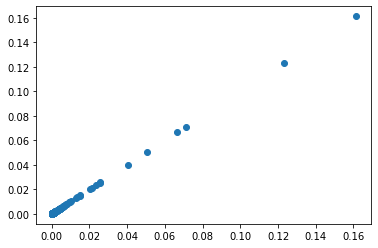

In [90]:
_ = plt.scatter(
    np.exp(current_data.data.log_destination_attraction).mean('id').values.squeeze(),
    ins.data.destination_attraction_ts.squeeze()
)

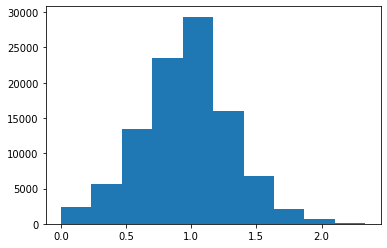

In [91]:
_ = plt.hist(current_data.data.alpha.squeeze().values)

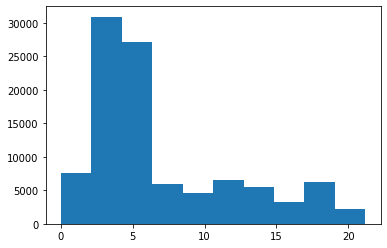

In [92]:
_ = plt.hist(current_data.data.beta.squeeze().values)

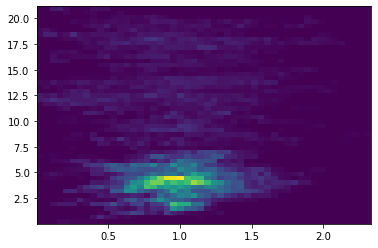

: 

In [93]:
_ = plt.hist2d(current_data.data.alpha.squeeze().values,current_data.data.beta.squeeze().values,bins = 50)